In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

d:\Anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


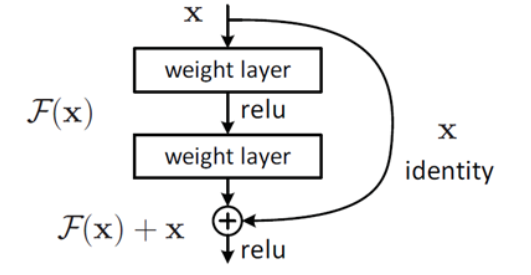
<br>
这种跳跃连接就叫做shortcut connection（类似电路中的短路）。上面这种两层结构的叫BasicBlock，一般适用于ResNet18和ResNet34
而ResNet50以后都使用下面这种三层的残差结构叫Bottleneck<br>
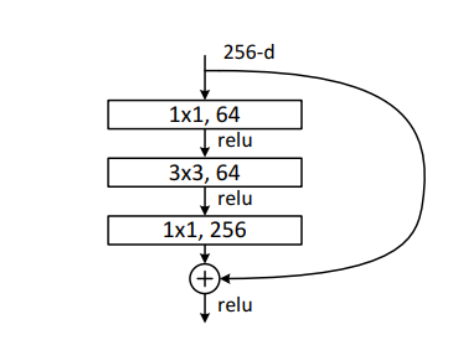
<br>
最明显的区别就是，Bottleneck中有三层，中间层是kernel为3的卷积层，一头一尾则是kernel为1的卷积，明显是用来做通道数的变换。



In [2]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=[1, 1, 1], padding=[0, 1, 0], flag=False):
        """
        in_channels: 输入的通道
        out_channels: 卷积后输出的通道
        """
        super(BottleNeck, self).__init__()
        extension = 4 # 扩充的倍数
        # 残差
        self.layers = nn.Sequential(
            # 1*1
            nn.Conv2d(in_channels, out_channels, 1, stride[0], padding[0]),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # 3*3
            nn.Conv2d(out_channels, out_channels, 3, stride[1], padding[1]),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # 1*1
            nn.Conv2d(out_channels, out_channels*extension, 1, stride[2], padding[2]),
            nn.BatchNorm2d(out_channels*extension),
        )

        #shortchut connection
        self.shortcut = nn.Sequential()
        # 如果输入输出通道不一致，或者使用了
        if flag:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*extension, 1, stride[1], 0),
                nn.BatchNorm2d(out_channels*extension)
            )
    
    def forward(self, x):
        # 残差计算前向传播
        out = self.layers(x)
        # 添加shortcut
        out += self.shortcut(x)
        # 使用ReLU激活
        out = F.relu(out)
        return out


In [3]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        # 第一个卷积部分，不使用BottleNeck
        # 3*224*224 -> 64*56*56
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1)
        )
        # conv2 BottleNeck*3
        # 64*56*56 -> 256*56*56
        self.conv2 = self.make_layers(BottleNeck, 64, 
                                      [[1, 1, 1]]*3, # 新学到的写法
                                      [[0, 1, 0]]*3) # 也可以写个新方法用来制作参数列表
        # conv3 BottleNeck*4
        # 256*56*56 -> 512*28*28
        self.conv3 = self.make_layers(BottleNeck, 128,
                                      [[1,2,1]]+[[1,1,1]]*3,
                                      [[0,1,0]]*4)

        # conv4 BottleNeck*6
        # 512*28*28 -> 1024*14*14
        self.conv4 = self.make_layers(BottleNeck, 256,
                                      [[1, 2, 1]]+[[1,1,1]]*5,
                                      [[0, 1, 0]]*6)
        
        # conv5 BottleNeck*3
        # 1024*14*14 -> 2048*7*7
        self.conv5 = self.make_layers(BottleNeck, 512,
                                      [[1, 2, 1]]+[[1,1,1]]*2,
                                      [[0, 1, 0]]*3)
        
        # full connection
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, num_classes)
        )
    
    def make_layers(self, block, out_channels, strides, paddings):
        """
        用于生成若干个BottleNeck
        block: BottleNeck
        out_channels: 该block输出的通道维度
        strides: 步长列表
        paddings: 填充列表
        """
        # 用于存放生成BottleNeck的层
        layers = []
        extension = 4
        flag = True
        for i in range(len(strides)):
            # 添加BottleNeck
            layers.append(block(self.in_channels, out_channels, 
                                strides[i], paddings[i], flag))
            flag = False
        
            # 将本次输出通道数设置为下次输入通道数
            self.in_channels = out_channels*extension
        
        return nn.Sequential(*layers)
        
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        logits = self.fc(out)
        return logits


In [4]:
model = ResNet50(10)
model

ResNet50(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BottleNeck(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))


In [5]:
# 测试输出
num = torch.rand([8,3, 224 ,224])
logits = model.forward(num)
probas = F.softmax(logits, dim=1)
probas

tensor([[0.0889, 0.1032, 0.1077, 0.1508, 0.1096, 0.0831, 0.0991, 0.0229, 0.1249,
         0.1098],
        [0.0973, 0.0982, 0.1071, 0.1246, 0.1146, 0.0723, 0.1134, 0.0255, 0.1203,
         0.1268],
        [0.0912, 0.0954, 0.1115, 0.1545, 0.1118, 0.0825, 0.0993, 0.0249, 0.1030,
         0.1259],
        [0.0934, 0.0963, 0.1057, 0.1677, 0.1038, 0.0744, 0.0902, 0.0250, 0.1241,
         0.1194],
        [0.0713, 0.0894, 0.1055, 0.1418, 0.1404, 0.0827, 0.1000, 0.0236, 0.1253,
         0.1200],
        [0.0970, 0.0954, 0.1106, 0.1571, 0.1133, 0.0748, 0.0983, 0.0236, 0.1227,
         0.1073],
        [0.0792, 0.1068, 0.1230, 0.1468, 0.1247, 0.0869, 0.0909, 0.0245, 0.1096,
         0.1076],
        [0.0801, 0.0920, 0.0879, 0.1427, 0.1348, 0.0907, 0.1148, 0.0244, 0.1170,
         0.1156]], grad_fn=<SoftmaxBackward0>)

In [6]:
preds = torch.max(probas, dim=1)
print(preds)


torch.return_types.max(
values=tensor([0.1508, 0.1268, 0.1545, 0.1677, 0.1418, 0.1571, 0.1468, 0.1427],
       grad_fn=<MaxBackward0>),
indices=tensor([3, 9, 3, 3, 3, 3, 3, 3]))
